# CoCoScore Implementation

This notebook consists of implementing the [CoCoScore](https://www.biorxiv.org/content/10.1101/444398v1) literature model for comparison. We report performance as area under the precision recall curve (AUPR) and area under the receiver operating curve (AUROC). In both cases the greater the area the better the model is.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import re
import sys

sys.path.append(os.path.abspath('../../../../modules'))

import operator
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score, confusion_matrix
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.rnn_base import mark_sentence
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

from metal.analysis import lf_summary
from metal.label_model import LabelModel
from metal.utils import plusminus_to_categorical

from gensim.models import FastText
from gensim.models import KeyedVectors

from utils.notebook_utils.label_matrix_helper import label_candidates, get_auc_significant_stats
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes, generate_results_df
from utils.notebook_utils.plot_helper import plot_curve, plot_label_matrix_heatmap

In [4]:
CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])

In [5]:
quick_load = True

In [6]:
total_candidates_df = pd.read_table("../../dataset_statistics/results/all_ctd_map.tsv.xz")
total_candidates_df.head(2)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,doid_id,doid_name,resource,resource_id,drugbank_id,drug_name,disease,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,DOID:2531,hematologic cancer,CSP,2004-1600,DB00007,Leuprolide,NaN,NaN,0,6,1,0.58699,9,1.0,1.0,0.0,77006168,Follicular mucinosis and mycosis-fungoides-lik...,16,26220260
1,DOID:2531,hematologic cancer,CSP,2004-1600,DB00007,Leuprolide,NaN,NaN,0,6,1,0.58699,9,1.0,1.0,0.0,77006178,We report an unusual case of disseminated urti...,35,26208290


In [7]:
spreadsheet_names = {
    'dev': '../../data/sentences/sentence_labels_dev.xlsx',
    'test': '../../data/sentences/sentence_labels_test.xlsx'
}

In [8]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_ctd")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [9]:
distant_supervision_marginals = pd.read_table("../../label_sampling_experiment/results/CtD/marginals/baseline_marginals.tsv.xz")
distant_supervision_marginals.head(2)

,pos_class_marginals,neg_class_marginals,candidate_id
0,0.975064,0.024936,65851
1,0.000191,0.999809,65856


In [10]:
all_embedded_cd_df = pd.read_table("../../word_vector_experiment/results/all_embedded_cd_sentences.tsv.xz")
all_embedded_cd_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,794,795,796,797,798,799,800,801,candidate_id,sen_length
0,0,1,2,3,4,5,6,7,8.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66204,64
1,42,0,43,2,44,45,46,47,48.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65956,38


In [11]:
word_vectors = pd.read_csv(
    "../../word_vector_experiment/results/compound_treats_disease_word_vectors.bin",
    sep=" ", skiprows=1, 
    header=None, index_col=0, 
    keep_default_na=False
)
word_vectors.head(2)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
",",0.002985,0.150970,-0.068927,-0.002493,-0.075059,-0.073242,-0.011505,0.031908,0.107073,0.073218,...,-0.070338,-0.159818,-0.073845,0.107458,0.120008,-0.019771,-0.26473,-0.077490,-0.035241,-0.209923
of,-0.337446,0.098459,-0.226047,-0.049098,-0.072348,-0.138533,-0.133182,0.146129,-0.041886,-0.035923,...,-0.069237,-0.220180,-0.088708,0.146678,-0.087326,-0.195603,-0.22727,0.066385,0.083240,0.096180


In [12]:
word_dict = pd.read_table("../../word_vector_experiment/results/compound_treats_disease_word_dict.tsv", keep_default_na=False)
reverse_word_dict = dict(zip(word_dict.index, word_dict.word))
word_dict = dict(zip(word_dict.word, word_dict.index))

In [13]:
total_training_sentences_df = (
    all_embedded_cd_df.merge(
        distant_supervision_marginals
        .assign(labels=lambda x: x.pos_class_marginals > 0.5)
        [["labels", "candidate_id"]]
        .astype({"labels":int}),
        on="candidate_id"
    )
)
total_training_sentences_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,795,796,797,798,799,800,801,candidate_id,sen_length,labels
0,42,0,43,2,44,45,46,47,48.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65956,38,0
1,85,86,87,88,75,35,89,86,46.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65862,36,0


In [14]:
total_dev_sentences_df = (
    all_embedded_cd_df.merge(
        candidate_dfs['dev']
        [["curated_ctd", "candidate_id"]],
        on="candidate_id"
    )
)
total_dev_sentences_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,795,796,797,798,799,800,801,candidate_id,sen_length,curated_ctd
0,55,1086,1087,1074,15,50,17,48,1088.0,450.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71443,19,0.0
1,1314,393,61,713,75,98,309,287,61.0,1315.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73193,60,0.0


In [15]:
total_test_sentences_df = (
    all_embedded_cd_df.merge(
        candidate_dfs['test']
        [["curated_ctd", "candidate_id"]],
        on="candidate_id"
    )
)
total_test_sentences_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,795,796,797,798,799,800,801,candidate_id,sen_length,curated_ctd
0,55,192,38,812,813,61,0,814,2.0,815.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69923,32,0.0
1,159,525,1219,206,35,431,817,375,15.0,197.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114024,29,0.0


In [16]:
def create_data_matrix(query_df, filename="sentences.txt"):
    search_regex = rf'(\b{word_dict["~~[[2"]}\b.+\b{word_dict["2]]~~"]}\b,)'
    search_regex += rf'|(\b{word_dict["~~[[1"]}\b.+\b{word_dict["1]]~~"]}\b,)'
    
    print(search_regex)
    data = []
    with open(filename, "w") as g:
        for index, row in tqdm_notebook(query_df.iterrows()):
            cand_str = ",".join(map(str, row.dropna().astype(int).values))
            pruned_str = re.sub(search_regex, "", cand_str)
            values = list(map(int, pruned_str.split(",")))
            g.write(f"__label__{values[-1]}\t")
            g.write("\t".join([reverse_word_dict[val] for val in values[:-2]]))
            g.write("\n")

In [17]:
query_df = (
    total_training_sentences_df
    [[col for col in total_training_sentences_df.columns if col not in ["sen_length"]]]
)
create_data_matrix(query_df, filename="training.txt")

(\b15\b.+\b17\b,)|(\b0\b.+\b2\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [18]:
query_df = (
    total_dev_sentences_df
    [[col for col in total_dev_sentences_df.columns if col not in ["sen_length"]]]
)
create_data_matrix(query_df, filename="dev.txt")

(\b15\b.+\b17\b,)|(\b0\b.+\b2\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [19]:
query_df = (
    total_test_sentences_df
    [[col for col in total_test_sentences_df.columns if col not in ["sen_length"]]]
)
create_data_matrix(query_df, filename="test.txt")

(\b15\b.+\b17\b,)|(\b0\b.+\b2\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [24]:
os.system("../../../../../fastText/fasttext supervised -input training.txt -output ctd_model -lr 0.005 -epoch 50 -dim 300 -wordNgrams 2")
os.system("../../../../../fastText/fasttext predict-prob ctd_model.bin dev.txt > dev_predictions.tsv")
os.system("../../../../../fastText/fasttext predict-prob ctd_model.bin test.txt > test_predictions.tsv")

0

In [25]:
precision, recall, _ = precision_recall_curve(
    total_dev_sentences_df.curated_ctd,
    pd.read_table('dev_predictions.tsv', header=None, sep=" ")[1]
)
auc(recall, precision)

0.1371295246754589

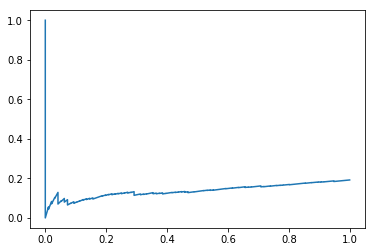

In [26]:
plt.plot(recall, precision)

In [27]:
fpr, tpr, _ = roc_curve(
    total_dev_sentences_df.curated_ctd,
    pd.read_table('dev_predictions.tsv', header=None, sep=" ")[1]
)
auc(fpr, tpr)

0.33147689768976896

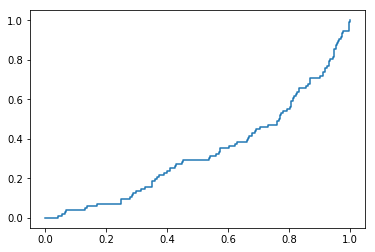

In [28]:
plt.plot(fpr, tpr)

In [31]:
query_df = (
    all_embedded_cd_df
    .assign(labels=0)
    [[col for col in all_embedded_cd_df.columns if col not in ["sen_length"]]]
)
create_data_matrix(query_df, filename="all_cd_sentences.txt")

(\b15\b.+\b17\b,)|(\b0\b.+\b2\b,)


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [32]:
os.system("../../../../../fastText/fasttext predict-prob ctd_model.bin all_cd_sentences.txt > all_cd_sentences_predictions.tsv")

0

In [34]:
predictions_df = pd.read_table("all_cd_sentences_predictions.tsv", header=None, names=["label", "predictions"], sep=" ")
predictions_df['candidate_id'] = all_embedded_cd_df.candidate_id.values
predictions_df.head(2)

,label,predictions,candidate_id
0,__label__0,0.989714,66204
1,__label__0,0.573373,65956


In [35]:
final_pred_df = (
    total_candidates_df
    [["doid_id", "drugbank_id", "candidate_id"]]
    .merge(predictions_df[["predictions", "candidate_id"]])
)
final_pred_df.head(2)

,doid_id,drugbank_id,candidate_id,predictions
0,DOID:2531,DB00007,26220260,0.955383
1,DOID:2531,DB00007,26208290,0.937528


In [36]:
added_scores_df = (
    final_pred_df
    .groupby(["doid_id", "drugbank_id"])
    .aggregate({"predictions": 'sum'})
    .reset_index()
)
added_scores_df.head(2)

,doid_id,drugbank_id,predictions
0,DOID:0050156,DB00104,0.922415
1,DOID:0050156,DB00129,2.746339


In [38]:
total_score = added_scores_df.predictions.sum()
disease_scores = added_scores_df.groupby("doid_id").agg({"predictions":"sum"}).reset_index()
disease_scores = dict(zip(disease_scores.doid_id, disease_scores.predictions))
drug_scores = added_scores_df.groupby("drugbank_id").agg({"predictions":"sum"}).reset_index()
drug_scores = dict(zip(drug_scores.drugbank_id, drug_scores.predictions))

alpha=0.65

final_scores_df = added_scores_df.assign(
    final_score=(
        added_scores_df.apply(
            lambda x: pd.np.exp(
                    alpha*pd.np.log(x['predictions']) + (1-alpha)*(
                    pd.np.log(x['predictions']) + pd.np.log(total_score) - 
                    pd.np.log(disease_scores[x['doid_id']]) - pd.np.log(drug_scores[x['drugbank_id']])
                )
            ), 
            axis=1
        )
    )
)
final_scores_df.head(2)

,doid_id,drugbank_id,predictions,final_score
0,DOID:0050156,DB00104,0.922415,0.78957
1,DOID:0050156,DB00129,2.746339,4.15409


In [39]:
score_with_labels_df = (
    final_scores_df
    .merge(
        total_candidates_df[["drugbank_id", "doid_id", "hetionet"]],
        on=["drugbank_id", "doid_id"]
    )
    .drop_duplicates()
)
score_with_labels_df.head(2)

,doid_id,drugbank_id,predictions,final_score,hetionet
0,DOID:0050156,DB00104,0.922415,0.78957,0
1,DOID:0050156,DB00129,2.746339,4.15409,0


In [41]:
score_with_labels_df.drop("predictions", axis=1).to_csv("cd_edge_prediction_cocoscore.tsv", sep="\t", index=False)

In [40]:
fpr, tpr, _ = roc_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(fpr, tpr))

precision, recall, _ = precision_recall_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(recall, precision))

0.9083671666434774
0.3157177057335052
